# AБ-тестирование

#### Импорты

In [1]:
import numpy as np
import pandas as pd
%pylab inline
import scipy
from scipy import stats
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.descriptivestats import sign_test

Populating the interactive namespace from numpy and matplotlib


#### Переменные

In [3]:
data = np.random.normal(2600, 3400, 100)
mu =2900

d1 = np.random.normal(1, 100, 100)
d2 = np.random.normal(1, 100, 100)

d_ber = np.array(60*[1] + 40*[0])
d_ber_alter = np.array(75*[1] + 25*[0])

#### Функции

In [ ]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [ ]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [ ]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [ ]:
def proportions_diff_confint_rel(sample1, sample2, alpha = 0.05):
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    sample = zip(sample1, sample2)
    n = len(sample)
        
    f = sum([1 if (x[0] == 1 and x[1] == 0) else 0 for x in sample])
    g = sum([1 if (x[0] == 0 and x[1] == 1) else 0 for x in sample])
    
    left_boundary = float(f - g) / n  - z * np.sqrt(float((f + g)) / n**2 - float((f - g)**2) / n**3)
    right_boundary = float(f - g) / n  + z * np.sqrt(float((f + g)) / n**2 - float((f - g)**2) / n**3)
    return (left_boundary, right_boundary)

In [ ]:
def proportions_diff_z_stat_rel(sample1, sample2):
    sample = zip(sample1, sample2)
    n = len(sample)
    
    f = sum([1 if (x[0] == 1 and x[1] == 0) else 0 for x in sample])
    g = sum([1 if (x[0] == 0 and x[1] == 1) else 0 for x in sample])
    
    return float(f - g) / np.sqrt(f + g - float((f - g)**2) / n )

In [8]:
def permutation_t_stat_1sample(sample, mean):
    t_stat = sum(map(lambda x: x - mean, sample))
    return t_stat

In [9]:
def permutation_zero_distr_1sample(sample, mean, max_permutations = None):
    centered_sample = map(lambda x: x - mean, sample)
    if max_permutations:
        signs_array = set([tuple(x) for x in 2 * np.random.randint(2, size = (max_permutations, 
                                                                              len(sample))) - 1 ])
    else:
        signs_array =  itertools.product([-1, 1], repeat = len(sample))
    distr = [sum(centered_sample * np.array(signs)) for signs in signs_array]
    return distr

In [10]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_1sample(sample, mean)
    
    zero_distr = permutation_zero_distr_1sample(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [19]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [20]:
def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [21]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [22]:
def permutation_test_ind(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

#### Введение

АБ-тестирование - контрольная группа элементов сравнивается с наборами тестовых групп, в которых несколько показателей изменены, для того чтобы понять какие изменения улучшают целевой показатель. Важное свойство - устойчивость, незначительные изменения -> незначительное влияние и наоборот. Обычно полезно до АБ тестов выполнить АА тесты, в которых группам показываются одинаковые показатели. Если изменений нет или они незначительны, значит все ок.

Параметрические критерии - в проверяемых гипотезах высказывается предположение о параметре распределения.

#### Одновыборочный критерий Стьюдента. 

Есть выборка Х с нормальным распределением N(m,sigma^2). (Вес рождаемости детей из малообеспеченных семей.)

Нулевая гипотеза - средние равны. H0: m = m0. (Программа не эффективна, вес в среднем не меняется)

Альтернативная - средние как то не равны H1: 

m < m0 -> F_st (t) (Программа эффективна положительно, вес в среднем увеличивается)

m > m0 ->  1-F_st(t) (Программа эффективна отрицательно, вес в среднем уменьшается)

m != m0 -> 2*(1 - F_st(t)) (Программа эффективна, вес в среднем как то меняется)


Статистика Т = $\frac{X_{vib_sr} - m_0}{sigma_{vib_sr} / \sqrt{n}}$ 

Нулевое распределение St(n-1)



In [ ]:
#P-value.Если > 0.05 значит H0 верна, mu действительно где-то по середине
stats.ttest_1samp(data, mu)

#95% доверительный интервал среднего
zconfint(data)

#### Двухвыборочный критерий Стьюдента (независимые выборки)

Есть 2 выборки X1 и X2

...

Статистика $T=\frac{X_{1 sr} - X_{2 sr}}{\sqrt{sigma_{1 sr}^2 / n1 + sigma_{2 sr}^2 / n2}}$

Нулевое распределение приблизительно St(v), где v - число степеней свободы

Используется когда размеры выборок одинаковы или знак неравенста размеров такой же как у дисперсий.

In [ ]:
#p > 0.05 значит среднии выборок равны, H0 - верна
scipy.stats.ttest_ind(d1, d2, equal_var = False)

#95% интервал разности, в интервале есть 0 -> сделать вывод нельзя, если интервал всегде > 0, то H0 отвергается
cm = CompareMeans(DescrStatsW(d1), DescrStatsW(d2))
cm.tconfint_diff(usevar='unequal')

#### Двухвыборочный критерий Стьюдента (зависимые выборки)

Есть 2 выборки X1 и X2. Данный критерий эквивалентен одновыборочному t-критерию, применимому к выборке попарных разностей.

...

Статистика $T =\frac{X_{1 sr} - X_{2 sr}}{sigma / \sqrt{n}}$ ,

$sigma^2 = \frac{1}{n-1} * \sum(D_i - D_{sr})^2$

$D_i = X_{1i} - X_{2i}$

In [ ]:
#p > 00.5 значит H0 верна и средние похожи
stats.ttest_rel(d1, d2)

#95% интервал попарной разности
DescrStatsW(d1 - d2).tconfint_mean()

#### Проверка на нормальность

Есть выборка X, H0 - она из нормального распределения. X делится на k интервалов. Для каждого интервала считается количество элементов ni и вероятность попадания в интервал при верной H0 - pi. 

Статистика Хи квадрат $T = \sum{\frac{(n_i - n*p_i)^2}{n*p_i}}$, приблизительно распределение Хи со степенью совободы k-1 (m и sigma заданы) или k-3(не заданы).

Если статистика из расперделения Хи, то H0-верна. Значение зависит от выбора интервалов.

Также можно построить Q-Q график. Выборка сортируется и отображается на график в связке с средними квантилями нормального распределения. На данном графике основан критерий Шапиро-Уилка, который проверяет насколько точки графика отклоняются от прямой. Считается на основе табулированных средних нормального распределения.

Общий подход: если признак бинарный или категориальный, то используем что нить другое. Если шкала признака непрерывна, то смотрим по Q-Q. Если выбранный метод чувствителен к отклонениям, то лучше еще построить критерий Шапиро-Уилка.

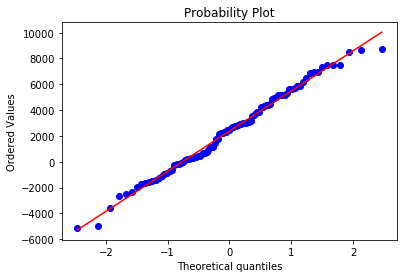

In [15]:
#Q-Q
stats.probplot(data, dist="norm", plot=pylab)
pylab.show()

Критерий Шапиро-Уилка (p > 0.56 -> H0 верна и данные распределены нормально)

In [18]:
stats.shapiro(data)

(0.988703191280365, 0.5614041090011597)

#### Интервальная оценка доли (Бернули)

Пример задачи: Интервально оценить долю носителей генов m из популяции размера n.

In [41]:
proportion_confint(sum(d_ber),len(d_ber),method = 'wilson')

(0.5020025867910618, 0.6905987135675411)

In [42]:
proportion_confint(sum(d_ber_alter),len(d_ber_alter),method = 'wilson')

(0.656955364519384, 0.8245478863771232)

Интервалы двух выборок пересекаются, поэтому сделать вывод однозначно нельзя.

#### Интервальная оценка  разности долей (независимые выборки)

Для независимых выборок. Пример: при испытаниях лекарства есть 2 выборки испытуемых X1 и X2, после эксперимента лучше стало n из X1 и m из X2. Построить доверительный интервал для улучшения состояния испытуемых.

In [48]:
#95% интервал разности долей, обе границы интервала < 0, значит альтернатива значимо лучше
proportions_diff_confint_ind(d_ber, d_ber_alter)

(-0.27814927412384116, -0.021850725876158883)

In [52]:
#p-value < 0.05 значит среднее d_ber < среднего d_ber_alter -> H0 что средние одинаковы неверна
proportions_diff_z_test(proportions_diff_z_stat_ind(d_ber, d_ber_alter),'less')

0.011770029130588954

#### Интервальная оценка разности долей (зависимые выборки)

Для зависимых выборок. Пример: при тестировании новой кнопки есть 2 выборки лайков, которые ставили одни и те же люди. Построить доверительный интервал для повышения лайков при использовании новой кнопки.

In [145]:
#Доверительный интервал разности зависимых выборок показывает, что альтернатива значимо лучше.
proportions_diff_confint_rel(d_ber, d_ber_alter)

(-0.2199847125905723, -0.08001528740942768)

In [56]:
#p-value очень мал, что указывает на большую уверенность в ложности H0.
proportions_diff_z_test(proportions_diff_z_stat_rel(d_ber, d_ber_alter), 'less')

1.3296309275393274e-05

#### Критерий знаков

Используется когда распределения выборки X из неизвестно. 

Для одной выборки.
Пример: есть 23 наблюдения длительности ремонта. H0: медиана X = 8ч., H1: медиана != 8ч. Считаем статистику $T=\sum(X_i > 8)$. Если H0 справедлива, то T имеет биноминальное распределение с параметрами n и 0.5. В итоге ремонт в 23 случаях длился > 8 часов, p_val = 0.105. Нулевая гипотеза не отвергается. 

In [4]:
sign_test(d1, 0.5)

(-2.0, 0.7643534344026666)

Для связных выборок T = сумме индикаторов того что X_1i > X_2i. H0: P(X1 > X2) = 0.5. H1: P(X1 > X2) > 0.5. Нулевое распределение такое же. Пример: есть 2 классификатора 14 датасетов. По оценкам точности можно проверить какой классификатор лучше.

In [13]:
sign_test(d1 - d2)

(4.0, 0.4841184136072908)

#### Критерий рангов

Также используется когда распределение выборки неизвестно. Выборки превращают в ранги, затем делается какое-то дополни- тельное предположение, и на основании этого предположения получается, что разные конфигурации этих рангов при справедливости нулевой гипотезы могут реализоваться с равной вероятностью. Далее необходимо перебрать все конфигурации, и на каждой посчитать значение статистики — таким образом оценивается ее нулевое распределение.

Для одной выборки. Строим вариационный ряд(упорядочиваем элементы по неубыванию). Совпадающие элементы образуют связки и получают общий ранг = (k1+k2)/2. Ранг - позиция в вариационном ряду. Пример: есть 23 дивана, проверить соответствует ли длина стандартному размеру m. Распределение T - табличное.

H0: medX=m

$T = \sum(rank(|X_i-m|) * sign(X_i - m))$ 

In [5]:
stats.wilcoxon(d1 - 0.5)

WilcoxonResult(statistic=2450.0, pvalue=0.7965038710035247)

Для связных выборок. Нулевое распределение T также табличное.

H0: med(X1-X2)=0. 

H1: !=. 

$T = \sum(rank(|X_{1i}-X_{2i}|) * sign(X_{1i}-X_{2i}))$

In [16]:
stats.wilcoxon(d1 - d2)

WilcoxonResult(statistic=2317.0, pvalue=0.4745030356140598)

Для независимых выборок. Нулевое распределение T также табличное. Перед расчетом T выборки объединяются. Если H0 справедлива, то ранг который вычисляется в вариационном ряду по первой выборке, также мог реализоваться и во второй.

H0: F_x1(x) = F_x2(x)  

H1: F_x1(x) = F_x2(x + delta)

$T = \sum(rank(X_{1i})$ 

In [18]:
stats.mannwhitneyu(d1, d2)

MannwhitneyuResult(statistic=4726.0, pvalue=0.2519816315599859)

#### Перестановочный критерий

Перестановочные критерии принимают на вход выборку (или выборки), считают на них какую-то статистику. Далее делается дополнительное предположение о распределении, из которого эти выборки взяты. Это пред- положение порождает множество перестановок исходных данных, которые могли реализоваться с одинаковой вероятностью, если нулевая гипотеза справедлива. На этих перестановках вычисляется значение статистики и таким образом оценивается ее нулевое распределение.

Все то же самое что и ранговый, за исключением шага превращения наблюдений в ранги и вместо вычитания медианы используется вычитание мат. ожидания. Соответственно предположение - функция F(x) симметрична относительно мат. ожидания. Фактический уровень значимости - доля перебираемых перестановок, на которых получается такое же или более экстремальное значение T. Статистику перестановочных критериев можно выбирать по разному: сумма элементов, выборочное среднее и др.

In [11]:
#Одна выборка
permutation_test(d1, 0.5, 10000)

0.8036

In [17]:
#Зависимые выборки
permutation_test(d1-d2, 0.5, 10000)

0.5681

In [23]:
#Независимые выборки
permutation_test_ind(d1, d2, max_permutations = 10000)

0.5269

#### Метод бутстрепа

На вход принимается выборка или выбор- ки, считается значение статистики, которая оценивает интересующий параметр. Далее на основании исходных данных генерируется множество бутстреп-псевдовыборок, и на этих псевдовыборках вычисляются значения интересующей статистики, то есть оценивается ее распределение. 

Не используется дополнительное предположение. Бутстреп- псевдовыборки могут содержать по несколько копий элементов исходной выборки, а перестановки нет.

